In [1]:
import numpy as np
import os
import pandas as pd
import sys
import glob
import json
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy as dcopy

sys.path.append(os.path.join('..', '..', 'gw_detection_ias'))
import utils as ias_utils
import triggers_single_detector as trig
#### NOTE that this inmport a bunch of lists and dicts into
## the base namespace, so if you see a variable or function and
## wonder where is was defined, check o3a_catalog_tables.py
from o3a_catalog_tables import *

sys.path.append('..')
from cogwheel import postprocessing, sampling, posterior, gw_prior
from cogwheel import _private_ias, utils, data, waveform, grid, prior
from cogwheel import cosmology as cosmo
from _private_scratch import analysis_handle as ahand
from _private_scratch import parameter_aliasing as aliasing
from _private_scratch import parameter_label_formatting as labform
from _private_scratch import pe_plotting as cwplot
from _private_scratch import standard_intrinsic_transformations as pxform

#### EVENTS WITH COGWHEEL PE:
all_pe_evnames = ['GW150914',
 'GW151012',
 'GW151216',
 'GW151226',
 'GW170104',
 'GW170121',
 'GW170202',
 'GW170304',
 'GW170403',
 'GW170425',
 'GW170608',
 'GW170727',
 'GW170729',
 'GW170809',
 'GW170814',
 'GW170817A',
 'GW170818',
 'GW170823',
 'GW190408_181802',
 'GW190412',
 'GW190412_053044',
 'GW190413_052954',
 'GW190413_134308',
 'GW190421_213856',
 'GW190424_180648',
 'GW190426_152154',
 'GW190503_185404',
 'GW190510_201259',
 'GW190512_180714',
 'GW190513_205428',
 'GW190514_065416',
 'GW190517_055101',
 'GW190519_153544',
 'GW190521',
 'GW190521_074359',
 'GW190527_092055',
 'GW190602_175927',
 'GW190605_053717',
 'GW190606_061230',
 'GW190611_133220',
 'GW190620_030421',
 'GW190625_013821',
 'GW190625_074145',
 'GW190629_211545',
 'GW190630_185205',
 'GW190701_203306',
 'GW190704_104834',
 'GW190705_225533',
 'GW190706_222641',
 'GW190707_083226',
 'GW190707_093326',
 'GW190708_232457',
 'GW190711_030756',
 'GW190718_160159',
 'GW190719_215514',
 'GW190720_000836',
 'GW190725_174728',
 'GW190727_060333',
 'GW190728_064510',
 'GW190731_140936',
 'GW190803_022701',
 'GW190805_211137',
 'GW190814',
 'GW190814_192009',
 'GW190818_232544',
 'GW190821_124821',
 'GW190828_063405',
 'GW190828_065509',
 'GW190906_054335',
 'GW190908_161547',
 'GW190908_182359',
 'GW190909_114149',
 'GW190910_012619',
 'GW190910_112807',
 'GW190915_235702',
 'GW190916_200658',
 'GW190917_114810',
 'GW190920_113516',
 'GW190924_021846',
 'GW190926_050336',
 'GW190929_012149',
 'GW190930_133541']

# ones which also have version sampled with comoving VT prior:
all_pe_evnames_comov = ['GW190426_152154',
 'GW190510_201259',
 'GW190605_053717',
 'GW190606_061230',
 'GW190611_133220',
 'GW190625_013821',
 'GW190625_074145',
 'GW190629_211545',
 'GW190704_104834',
 'GW190705_225533',
 'GW190707_083226',
 'GW190711_030756',
 'GW190718_160159',
 'GW190725_174728',
 'GW190805_211137',
 'GW190814_192009',
 'GW190818_232544',
 'GW190821_124821',
 'GW190906_054335',
 'GW190908_161547',
 'GW190908_182359',
 'GW190910_012619',
 'GW190916_200658',
 'GW190917_114810',
 'GW190920_113516',
 'GW190926_050336']

def fmt(num, **kwargs):
    if hasattr(num, '__len__'):
        return [fmt(v, **kwargs) for v in num]
    return labform.fmt_num(num, **kwargs)

162 events, 34 from LVC catalog ({'GW190917_114629'} required shift) + 2 from LVC marginals
missing 3 with HL:
['GW190521_030229', 'GW190924_021846', 'GW190403_051519']
missing 6 LV and HV events:
['GW190910_112807', 'GW190620_030421', 'GW190708_232457', 'GW190630_185205', 'GW190814_211039', 'GW190925_232845']

restricting to IFAR > .5 O3a:
52 events, 33 from LVC catalog ({'GW190917_114629'} required shift) + 1 from LVC marginals
missing 4 with HL:
['GW190701_203306', 'GW190521_030229', 'GW190924_021846', 'GW190403_051519']
missing 6 LV and HV events:
['GW190910_112807', 'GW190620_030421', 'GW190708_232457', 'GW190814_211039', 'GW190630_185205', 'GW190925_232845']

restricting to pastro > .5:
42 events, 31 from LVC catalog + 1 from LVC marginals
missing 6 with HL:
['GW190917_114630', 'GW190701_203306', 'GW190521_030229', 'GW190426_190642', 'GW190924_021846', 'GW190403_051519']
missing 6 LV and HV events:
['GW190910_112807', 'GW190620_030421', 'GW190708_232457', 'GW190814_211039', 'GW19

In [2]:
from IPython.display import IFrame
%matplotlib notebook
%config Completer.use_jedi = False

In [3]:
approximant = 'IMRPhenomXPHM'
prior_class = 'IASPrior'
prior_class_comoving = 'IASPriorComovingVT'
prior_class_aligned = 'AlignedSpinIASPrior'
prior_class_aligned_comoving = 'AlignedSpinIASPriorComovingVT'
parentdir = '/scratch/srolsen/GW/O3a/PE/'
# NOTE: all_ias_cands[evname] will give dict with trigger information if evname from O3a
## below are the most commonly used keys as lambda functions taking eventname argument
ifar_of_evname = lambda evn: all_ias_cands[evn]['ifar_years']
pastro_of_evname = lambda evn: all_ias_cands[evn]['pastro_mz']
snr2_of_evname = lambda evn: np.array([all_ias_cands[evn]['snr2_H1'], all_ias_cands[evn]['snr2_L1']])
calpha_of_evname = lambda evn: np.array(all_ias_cands[evn]['calpha'])

**EXAMPLE: Single Event**

In [4]:
evn_check = 'GW190821_124821'#'GW190707_093326'

### this has the trigger info
cdic_check = all_ias_cands.get(evn_check)
if cdic_check is not None:
    print(f'{evn_check}: IFAR = {fmt(ifar_of_evname(evn_check))} (y),',
          f'snr2[H,L] = {fmt(snr2_of_evname(evn_check))},',
          f'pastro = {ifar_of_evname(evn_check)}')
### IASPrior and IASPriorComovingVT latest PE results loaded if they exist
pecheck, pecheck_comov = None, None
if evn_check in all_pe_evnames:
    pecheck = ahand.AnalysisHandle.from_evname(evn_check)
    # after loading PE set name to include some info (used in plot titles/labels)
    pecheck.name = (f'IASPrior, lnLmax = '+fmt(pecheck.lnL(pecheck.best_par_dic))
                    +', lnLref = '+fmt(pecheck.lnL(pecheck.likelihood.par_dic_0)))
    print(f'--> {len(pecheck.samples)} samples from '+pecheck.name)
else:
    print(f'[[ NO Cogwheel PE of {evn_check} for IASPrior ]]')
if evn_check in all_pe_evnames_comov:
    pecheck_comov = ahand.AnalysisHandle.from_evname(evn_check, prior_name=prior_class_comoving)
    pecheck_comov.name = (f'IASPriorComovingVT, lnLmax = '+
        fmt(pecheck_comov.lnL(pecheck_comov.best_par_dic))+', lnLref = '
        +fmt(pecheck_comov.lnL(pecheck_comov.likelihood.par_dic_0)))
    print(f'--> {len(pecheck_comov.samples)} samples from '+pecheck_comov.name)
else:
    print(f'[[ NO Cogwheel PE of {evn_check} for IASPriorComovingVT ]]')

GW190821_124821: IFAR = 0.71 (y), snr2[H,L] = ['28', '49'], pastro = 0.7115068493150685
--> 97063 samples from IASPrior, lnLmax = 48, lnLref = 44
--> 98768 samples from IASPriorComovingVT, lnLmax = 48, lnLref = 44


In [5]:
#### See if there is also a run from IMRPhenomD
pecheckD, pecheckD_comov = None, None
if os.path.exists(utils.get_eventdir(parentdir, prior_class_aligned, evn_check)/'run_0'/'samples.feather'):
    pecheckD = ahand.AnalysisHandle.from_evname(evn_check, prior_name=prior_class_aligned, complete_samples=True)
    # after loading PE set name to include some info (used in plot titles/labels)
    pecheckD.name = (f'AlignedSpinIASPrior (IMRPhenomD), lnLmax = '+fmt(pecheckD.lnL(pecheckD.best_par_dic))
                    +', lnLref = '+fmt(pecheckD.lnL(pecheckD.likelihood.par_dic_0)))
    print(f'--> {len(pecheckD.samples)} samples from '+pecheckD.name)
else:
    print('[[ NO IMRPhenomD PE for', evn_check, ']]')

if os.path.exists(utils.get_eventdir(parentdir, prior_class_aligned_comoving, evn_check)/'run_0'/'samples.feather'):
    pecheckD_comov = ahand.AnalysisHandle.from_evname(evn_check, prior_name=prior_class_aligned_comoving, complete_samples=True)
    # after loading PE set name to include some info (used in plot titles/labels)
    pecheckD_comov.name = (f'AlignedSpinIASPriorComovingVT (IMRPhenomD), lnLmax = '+fmt(pecheckD_comov.lnL(pecheckD_comov.best_par_dic))
                    +', lnLref = '+fmt(pecheckD_comov.lnL(pecheckD_comov.likelihood.par_dic_0)))
    print(f'--> {len(pecheckD_comov.samples)} samples from '+pecheckD_comov.name)
else:
    print('[[ NO IMRPhenomD comoving PE for', evn_check, ']]')

--> 21663 samples from AlignedSpinIASPrior (IMRPhenomD), lnLmax = 37, lnLref = 34
--> 21531 samples from AlignedSpinIASPriorComovingVT (IMRPhenomD), lnLmax = 36, lnLref = 34


In [6]:
## EXAMPLE: take 2 samples from different regions and compute cosine
######################################################################
# get best samples at ~ equal mass (eqm) and extreme mass ratio (uneq)
pdic_eqm = pecheck.get_best_par_dics(key_rngs={'q': (0.4, 1)}, as_par_dics=False)
pdic_uneq = pecheck.get_best_par_dics(key_rngs={'q': (0, 0.4)}, as_par_dics=False)
# get frequency-domain waveforms (unwhitened) at all detectors
dets_h_f_eqm = pecheck.likelihood._get_h_f(pdic_eqm)
dets_h_f_uneq = pecheck.likelihood._get_h_f(pdic_uneq)
# get whitened time domain from these
dets_hw_t_eqm = pecheck.likelihood._get_whitened_td(dets_h_f_eqm)
dets_hw_t_uneq = pecheck.likelihood._get_whitened_td(dets_h_f_uneq)
# compute match at each detector
print(f'match at {[k for k in pecheck.evdata.detector_names]} =',
     fmt([ias_utils.match(h1, h2, allow_phase=False, allow_shift=False,
                          return_cov=False) for h1, h2 in
          zip(dets_hw_t_eqm, dets_hw_t_uneq)]))

match at ['H', 'L', 'V'] = ['0.96', '0.95', '0.96']


<IPython.core.display.Javascript object>


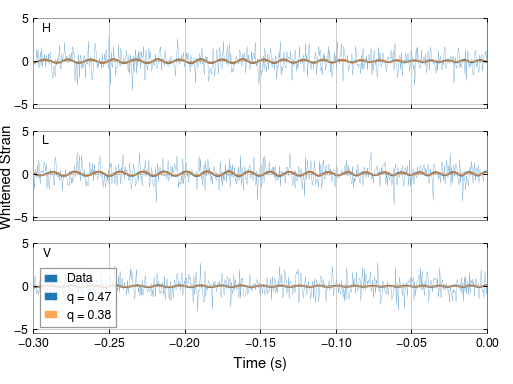

In [7]:
## EXAMPLE: plot whitened time domain waveform
#################################################
ff1 = pecheck.plot_whitened_wf(pdic_eqm, label=f"q = {fmt(pdic_eqm['m2']/pdic_eqm['m1'])}",
                               trng=(-.3, 0))
ff1 = pecheck.plot_whitened_wf(pdic_uneq, label=f"q = {fmt(pdic_uneq['m2']/pdic_uneq['m1'])}",
                               trng=(-.3, 0), fig=ff1, plot_data=False, alpha=0.7)
plt.legend()

<IPython.core.display.Javascript object>


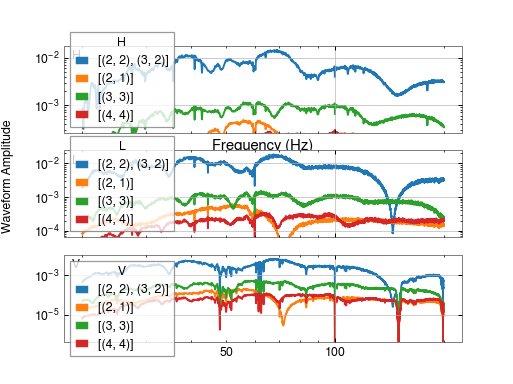

<IPython.core.display.Javascript object>


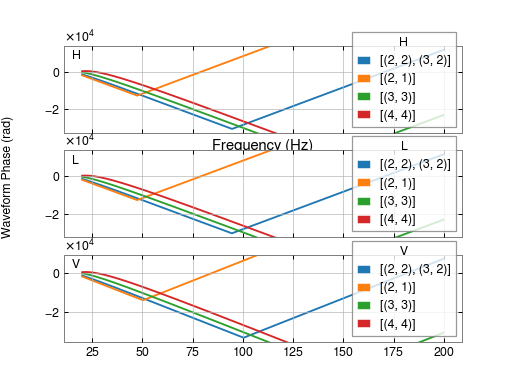

In [8]:
## EXAMPLE: plot waveform amplitudes and phases by modes
##########################################################
ff2, aax2 = pecheck.plot_wf_amp(pecheck.best_par_dic, whiten=True,
                                 by_m=True, xlim=(20, 200))
ff3, aax3 = pecheck.plot_wf_phase(pecheck.best_par_dic,
                                  by_m=True, xlim=(20, 200))

<IPython.core.display.Javascript object>


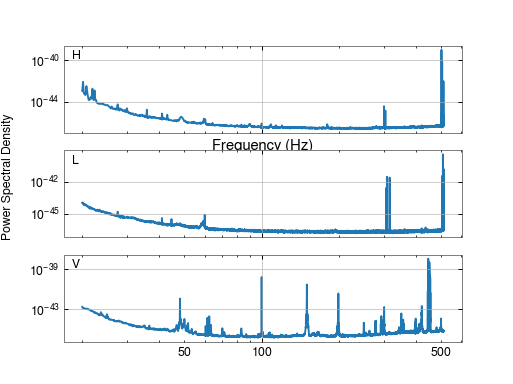

In [9]:
## EXAMPLE: plot PSD
######################
ff4, aax4 = pecheck.plot_psd(xlim=(20, 512))

<IPython.core.display.Javascript object>


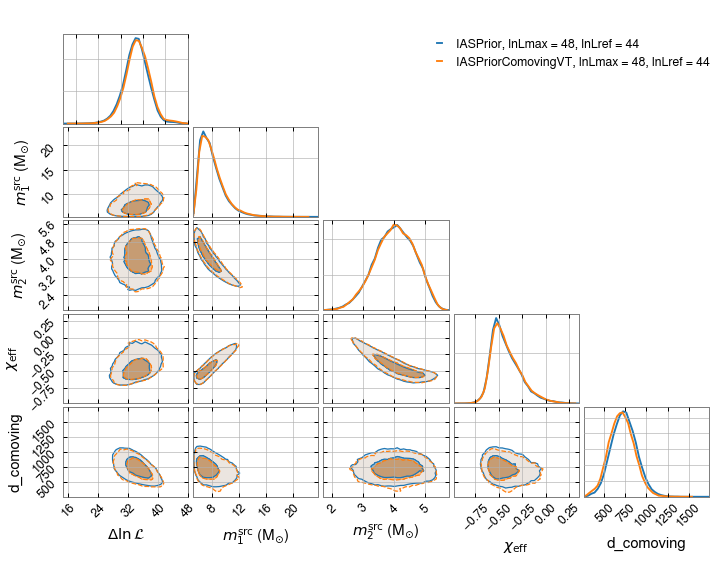

In [10]:
## EXAMPLE: CORNER PLOTTING
#################################################
parkeys = ['lnl', 'm1_source', 'm2_source', 'chieff', 'd_comoving']
## assume that the regular prior exists and if the comoving exists plot them
# both on a single corner plot, otherwise just the IASPrior
if pecheck_comov is not None:
    ff5, aax5 = pecheck.corner_plot_comparison([pecheck_comov], parkeys=parkeys)
else:
    ff5, aax5 = pecheck.corner_plot(parkeys)

<IPython.core.display.Javascript object>


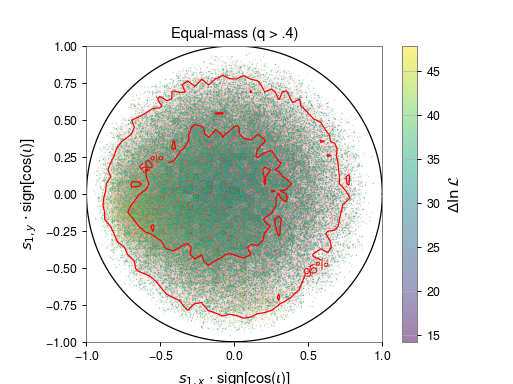

<IPython.core.display.Javascript object>


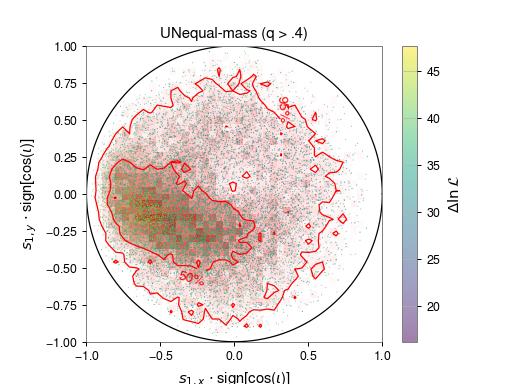

In [11]:
## EXAMPLE: plot in-plane spins
#################################
ff6, aax6 = pecheck.plot_inplane_spin(key_rngs={'q': (0.4, 1)}, title='Equal-mass (q > .4)', color_key='lnl')
ff7, aax7 = pecheck.plot_inplane_spin(key_rngs={'q': (0, 0.4)}, title='UNequal-mass (q > .4)', color_key='lnl')

<IPython.core.display.Javascript object>


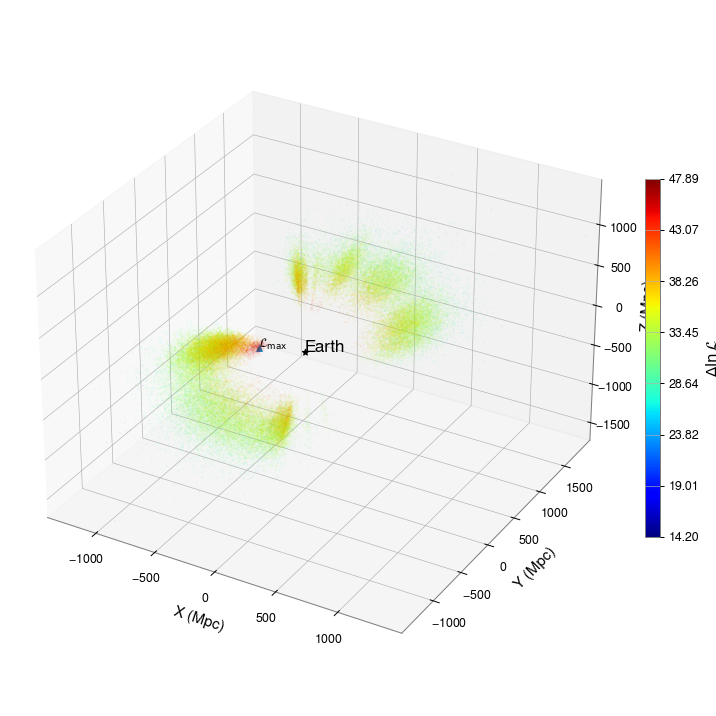

Plotted 97063 of 97063 samples


/home/srolsen/research/cogwheel/notebooks/../_private_scratch/pe_plotting.py:132: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


In [12]:
## EXAMPLE: plot location
############################
ff8, aax8 = pecheck.plot_3d_location(extra_point_dicts=[{**pecheck.best_par_dic, 'text': r'$\mathcal{L}_{\rm max}$',
                                                         's':20, 'm':'^'}])